### Analyses of the display images and dot locations in the behavioral paradigm

In [18]:

%matplotlib inline 
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#os.environ['HDF5_DISABLE_VERSION_CHECK']='True'

import pandas as pd

import numpy as np

from scipy import stats
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

from datasets.loaddata_g import *
coco_path='../../data/coco'

light_green = [144, 238, 144]
green = [0, 128, 0]
light_blue = [173, 216, 230]
steel_blue = [70, 130, 180]
red = [255, 0, 0]

# Load in the trial info file to be able to gather all subject responses for each trial

df_test = pd.read_excel("./datasets/dataset_grouping/test_data_grouping.xls", index_col=0)  
df_comp = df_test.copy()
df_comp




,image_id,img_id,img_name,same_diff,close_far,first_dot_xy,second_dot_xy,same_object_anns_ind,diff_object_anns_ind,distance
0,16,289393,000000289393.jpg,same,close,"[316, 251]","[210, 276]",2,1,108.908218
1,16,289393,000000289393.jpg,diff,close,"[316, 251]","[221, 204]",2,1,105.990566
2,16,289393,000000289393.jpg,same,far,"[316, 251]","[114, 262]",2,1,202.299283
3,16,289393,000000289393.jpg,diff,far,"[316, 251]","[135, 155]",2,1,204.882893
4,26,153299,000000153299.jpg,same,close,"[237, 264]","[206, 165]",1,0,103.740060
...,...,...,...,...,...,...,...,...,...,...
1019,4971,553788,000000553788.jpg,diff,far,"[317, 181]","[503, 257]",1,2,200.927848
1020,4998,394940,000000394940.jpg,same,close,"[213, 320]","[110, 285]",3,2,108.784190
1021,4998,394940,000000394940.jpg,diff,close,"[213, 320]","[261, 415]",3,2,106.437775
1022,4998,394940,000000394940.jpg,same,far,"[213, 320]","[171, 123]",3,2,201.427406


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:05<00:00, 189.20it/s]


<Figure size 400x400 with 0 Axes>

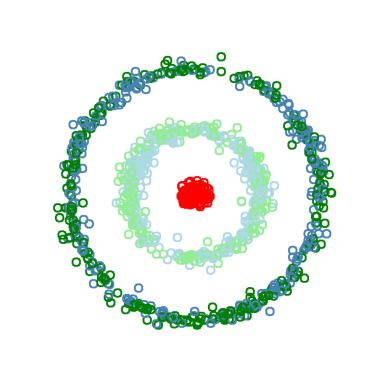

average distances between the dots for the four conditions
same close (104.3930634306601, 0.24296494794539739) in visual angles (3.070384218548827, 0.0071460278807469815)
diff close (104.11913968025627, 0.23673174810722156) in visual angles (3.062327637654596, 0.00696269847374181)
same far (202.68330515488202, 0.2181739523909587) in visual angles (5.961273681025942, 0.006416880952675255)
diff far (203.17689793419515, 0.2357756459977234) in visual angles (5.975791115711623, 0.0069345778234624535)


In [19]:
# plot all the dots color coded

from skimage.draw import circle_perimeter
import skimage.io as io
from shapely.geometry import Point
from skimage.draw import disk

canvas_dim = 600
canvas = 255*np.ones((canvas_dim,canvas_dim,3)).astype(np.uint8)

df_comp['img_shape'] = 1

all_dists = []

pix_per_vis_angle = 34   # numberof pixels in one degree visual angle

for t in tqdm(range(len(df_comp))):
    
    df_trial = df_comp.iloc[t]
    img, dots_coords, target = load_image(df_trial, 'val2017', coco_path)
    
    df_comp['img_shape'].iloc[t] = str(np.array(img).shape)

    img_id = df_comp['img_id'].iloc[t]
    sd = df_comp['same_diff'].iloc[t]
    cf = df_comp['close_far'].iloc[t]
    
    c1 = red
    if sd=='same':
        if cf=='close':
            c2 = light_green
        else: 
            c2 = green
    else:        
        if cf=='close':
            c2 = light_blue
        else: 
            c2 = steel_blue
    
    dots_colors = np.stack((c1,c2))
    
    # canvas = plot_dots(canvas, dots_coords['coords'], dots_colors)
    coords = dots_coords['coords']
    
    first_dot_x = int(canvas_dim/2 + img.size[0]*(coords[0][0] - 0.5))
    first_dot_y = int(canvas_dim/2 + img.size[1]*(coords[0][1] - 0.5))

    #center_dot = Point(first_dot_x,first_dot_y).buffer(8)

    second_dot_x = int(canvas_dim/2 + img.size[0]*(coords[1][0] - 0.5))
    second_dot_y = int(canvas_dim/2 + img.size[1]*(coords[1][1] - 0.5))
    #second_dot = Point(second_dot_x, second_dot_y).buffer(8)
    
    dist = np.linalg.norm(np.array([first_dot_x, first_dot_y]) - np.array([second_dot_x, second_dot_y]))
    all_dists.append(dist)

    canvas_2 = canvas.copy()

    rr, cc = disk((first_dot_y, first_dot_x), 8, shape=None)
    canvas[rr, cc,:] = c1

    rr, cc = disk((first_dot_y, first_dot_x), 5, shape=None)
    canvas[rr, cc,:] = canvas_2[rr, cc,:] # [255, 255, 255]

    canvas_2 = canvas.copy()

    rr, cc = disk((second_dot_y, second_dot_x), 8, shape=None)
    canvas[rr, cc,:] = c2
    
    rr, cc = disk((second_dot_y, second_dot_x), 5, shape=None)
    canvas[rr, cc,:] = canvas_2[rr, cc,:] #[255, 255, 255]
    
img_canvas = Image.fromarray(np.uint8(canvas))
#canvas = ImageOps.expand(img,border=1,fill='black')

#img_canvas.save("figures/all_dots.png")

fig = plt.figure(figsize=(4, 4))
fig, ax = plt.subplots()
ax.imshow(canvas)
ax.axis('off')
plt.show()
#fig.savefig("figures/all_dots_border.png", bbox_inches='tight', dpi=300)

df_comp['distance'] = all_dists
#all_dists = np.array(all_dists).reshape((2,2,-1))

# distances betweent the dots for different conditions 

print('average distances between the dots for the four conditions')
for cf in ['close', 'far']:
    for sd in ['same', 'diff']:

        df_comp_cond = df_comp[(df_comp['close_far']==cf) & (df_comp['same_diff']==sd)]
        
        summ =  df_comp_cond['distance'].mean(), df_comp_cond['distance'].sem()
        
        summ_visual_angle =  df_comp_cond['distance'].mean()/pix_per_vis_angle, df_comp_cond['distance'].sem()/pix_per_vis_angle
        print(sd, cf,summ, 'in visual angles',summ_visual_angle)

# TODO add the visual angle to the axes --  what is the number of pixels per visual angle? 

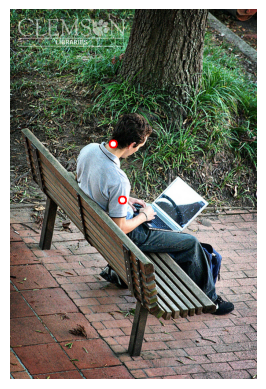

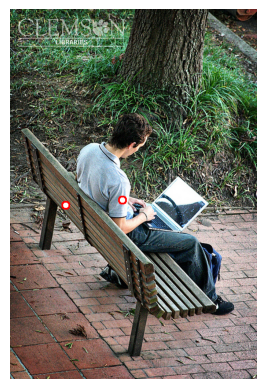

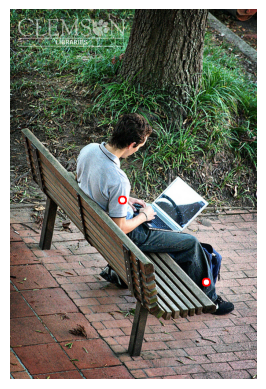

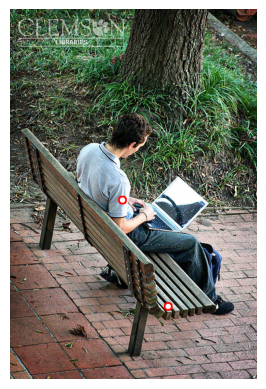

In [4]:
# create a sample experiment 

df_trial = df_comp[df_comp['img_id']== 459153 ]

canvas = 255*np.ones((canvas_dim,canvas_dim,3)).astype(np.uint8)
# img = Image.fromarray(np.uint8(canvas))
# canvas = ImageOps.expand(img,border=1,fill='black')

for t in range(len(df_trial)):
    
    img, dots_coords, target = load_image(df_trial.iloc[t], 'val2017', coco_path)
    canvas = 255*np.ones((img.size[1],img.size[0],3)).astype(np.uint8)
    img_with_dots = plot_dots(np.array(img), dots_coords['coords'])  #  np.array(canvas)
    
    canvas_with_dots = plot_dots(canvas, dots_coords['coords'])
    
#     Image.fromarray(np.uint8(img_with_dots))
#     img_canvas = Image.fromarray(np.uint8(canvas))

    Image.fromarray(np.uint8(canvas)).save(f"figures/img_with_dots_{t}.png")
    Image.fromarray(np.uint8(canvas)).save(f"figures/canvas_with_dots_{t}.png")

    fig, ax = plt.subplots(frameon=True)
    ax.imshow(img_with_dots)
    ax.axis('off')
    plt.show()
    #fig.savefig(f'figures/dots_{t}.png', bbox_inches='tight')


In [21]:
#df_comp.to_excel("./datasets/dataset_grouping/test_data_grouping.xls")

(640, 427, 3)
255.0


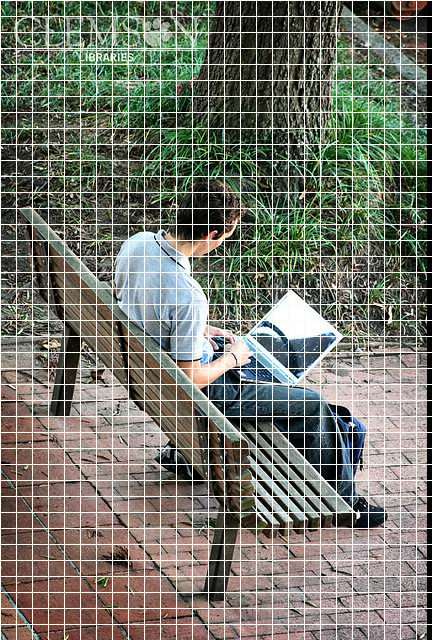

In [6]:
# plot a grid on the iamge to show different patches

from PIL import Image, ImageDraw

#img = Image.fromarray(img_with_dots)
# new_size = (608, 912)
# image = img.resize(new_size)
image = np.array(img)

print(image.shape)
init_image_size = image.shape
patch_size = 16


# Padding the image with zeros to fit multiple of patch-size
size_im = (
    int(np.ceil(image.shape[0] / patch_size) * patch_size),
    int(np.ceil(image.shape[1] / patch_size) * patch_size),
    image.shape[2]
)
paded = np.zeros(size_im)
paded[: image.shape[0], : image.shape[1], :] = image
print(np.max(paded))
image = Image.fromarray(np.uint8(paded))
    

# Draw some lines
draw = ImageDraw.Draw(image)
y_start = 0
y_end = image.size[1]

#h_featmap,w_featmap  (57, 38)

step_count_h, step_count_w = 40, 27

step_size_w = int(image.size[0] / step_count_w)
step_size_h = int(image.size[1] / step_count_h)

for x in range(0, image.size[0], step_size_w):
    line = ((x, y_start), (x, y_end))
    draw.line(line, fill=(251, 250,245))

x_start = 0
x_end = image.size[0]

for y in range(0, image.size[1], step_size_h):
    line = ((x_start, y), (x_end, y))
    draw.line(line, fill=(251, 250,245))


#image.save('figures/image_with_grid_orig.png')
image


In [7]:
# find the segment for each of the two main objects and add them to the df_test 

from pycocotools.coco import COCO

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.validation import make_valid
from skimage.color import gray2rgb

dataDir='../../data/coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# initialize COCO api for instance annotations
coco=COCO(annFile)
#img_ids = coco.getImgIds()


loading annotations into memory...
Done (t=10.52s)
creating index...
index created!


In [832]:
dot_r = 5

df_comp['same_object_anns_ind'] = -1
df_comp['diff_object_anns_ind'] = -1

for t in tqdm(range(0, len(df_comp), 4)):
    
    df_trial = df_comp.iloc[t]
    
    img_id = int(df_comp['img_id'].iloc[t])
    
    #imgIds = coco.getImgIds(imgIds = img_id)
    img = coco.loadImgs(img_id)[0] #imgIds[np.random.randint(0,len(imgIds))])[0]  # imgIds[0]


    try:
        # load and display image
        image = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
    except IOError:
        print('not found')

    if len(image.shape)<3 : image = gray2rgb(image)
    # plt.axis('off')
    # plt.imshow(I)
    # plt.show()

    # load and display instance annotations
    #plt.imshow(image); plt.axis('off')
    
    first_dot_xy = Point(np.fromstring(df_comp['first_dot_xy'].iloc[t][1:-1], dtype=float, sep=',')).buffer(dot_r) 

    same_second_dot_xy_0 = Point(np.fromstring(df_comp['second_dot_xy'].iloc[t][1:-1], dtype=float, sep=',')).buffer(dot_r) 
    diff_second_dot_xy_0 = Point(np.fromstring(df_comp['second_dot_xy'].iloc[t+1][1:-1], dtype=float, sep=',')).buffer(dot_r) 

    same_second_dot_xy_1 = Point(np.fromstring(df_comp['second_dot_xy'].iloc[t+2][1:-1], dtype=float, sep=',')).buffer(dot_r) 
    diff_second_dot_xy_1 = Point(np.fromstring(df_comp['second_dot_xy'].iloc[t+3][1:-1], dtype=float, sep=',')).buffer(dot_r) 
    
    
    annIds = coco.getAnnIds(imgIds=img['id'])  #catIds=catIds, ,  iscrowd=None
    anns = coco.loadAnns(annIds)
    
    same_object_anns_ind = -1
    diff_object_anns_ind = -1
    
    for s in range(len(anns)):
        
        obj_seg = anns[s]['segmentation']
        if (len(obj_seg) != 1): continue
        obj_seg = np.array(anns[s]['segmentation']).reshape(-1,2)
        obj_polygon = make_valid(Polygon(obj_seg))
        
        if same_object_anns_ind == -1 and obj_polygon.contains(first_dot_xy) and obj_polygon.contains(same_second_dot_xy_0) and obj_polygon.contains(same_second_dot_xy_1):
            same_object_anns_ind = s
            
        if diff_object_anns_ind == -1 and obj_polygon.contains(diff_second_dot_xy_0) and obj_polygon.contains(diff_second_dot_xy_1):
            diff_object_anns_ind = s


    for tt in range(4):
        df_comp['same_object_anns_ind'].iloc[t+tt] = same_object_anns_ind
        df_comp['diff_object_anns_ind'].iloc[t+tt] = diff_object_anns_ind
    
#df_comp.to_excel("./datasets/dataset_grouping/train_data_grouping.xls")  

  0%|          | 0/8206 [00:00<?, ?it/s]

In [840]:
df_comp[df_comp['same_object_anns_ind']==-1]

,image_id,img_id,img_name,same_diff,close_far,first_dot_xy,second_dot_xy,distance,same_object_anns_ind,diff_object_anns_ind


In [837]:
df_comp.to_excel("./datasets/dataset_grouping/train_data_grouping.xls") 

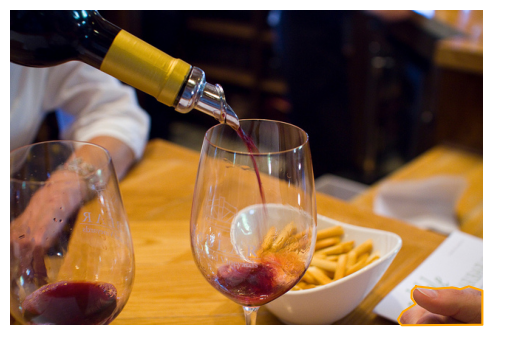

In [841]:
# center_polygon = Point(int(c/2), int(r/2)).buffer(center_polygon_radius) 
# inter.contains(Point(first_dot_x, first_dot_y).buffer(dot_radius)):

fig = plt.figure() #  (figsize=figsize)
plt.imshow(image); plt.axis('off')

x,y = obj_polygon.exterior.xy
plt.plot(x,y, color='orange')

# plt.imshow(image); plt.axis('off')
# annIds = coco.getAnnIds(imgIds=img['id'])  #catIds=catIds, ,  iscrowd=None
# anns = coco.loadAnns(annIds)
# coco.showAnns(anns[0:0+1])
# plt.show()